# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Array{Float64,1}:
 0.6358754068110235 
 0.544092669247872  
 0.27225025515011714
 0.2889081564099738 
 0.8733029636687413 
 0.7398262332351784 
 0.7183006683990212 
 0.9044874991010641 
 0.6211864763898296 
 0.6147884651585371 
 0.20684419054070635
 0.07023581889689301
 0.8923520807928966 
 ⋮                  
 0.3282120602202869 
 0.3160870908748834 
 0.32333029534599844
 0.1460714181702596 
 0.616723228129417  
 0.774300318214936  
 0.38394573978805435
 0.7681210173135782 
 0.6371300508840345 
 0.32644890692584494
 0.17017689221293097
 0.39619525761527585

In [2]:
sum(a)

4.999395011261333e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [3]:
@time sum(a)

  0.008013 seconds (5 allocations: 176 bytes)


4.999395011261333e6

In [4]:
@time sum(a)

  0.008002 seconds (5 allocations: 176 bytes)


4.999395011261333e6

In [5]:
@time sum(a)

  0.007741 seconds (5 allocations: 176 bytes)


4.999395011261333e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [6]:
# using Pkg
# Pkg.add("BenchmarkTools")

In [7]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [8]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [9]:
c_sum(a)

4.999395011261894e6

In [10]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [11]:
c_sum(a) - sum(a)  

5.615875124931335e-7

In [ ]:
≈  # alias for the `isapprox` function

In [12]:
?isapprox

search: isapprox



```
isapprox(x, y; rtol::Real=atol>0 ? 0 : √eps, atol::Real=0, nans::Bool=false, norm::Function)
```

Inexact equality comparison: `true` if `norm(x-y) <= max(atol, rtol*max(norm(x), norm(y)))`. The default `atol` is zero and the default `rtol` depends on the types of `x` and `y`. The keyword argument `nans` determines whether or not NaN values are considered equal (defaults to false).

For real or complex floating-point values, if an `atol > 0` is not specified, `rtol` defaults to the square root of [`eps`](@ref) of the type of `x` or `y`, whichever is bigger (least precise). This corresponds to requiring equality of about half of the significand digits. Otherwise, e.g. for integer arguments or if an `atol > 0` is supplied, `rtol` defaults to zero.

`x` and `y` may also be arrays of numbers, in which case `norm` defaults to `vecnorm` but may be changed by passing a `norm::Function` keyword argument. (For numbers, `norm` is the same thing as `abs`.) When `x` and `y` are arrays, if `norm(x-y)` is not finite (i.e. `±Inf` or `NaN`), the comparison falls back to checking whether all elements of `x` and `y` are approximately equal component-wise.

The binary operator `≈` is equivalent to `isapprox` with the default arguments, and `x ≉ y` is equivalent to `!isapprox(x,y)`.

Note that `x ≈ 0` (i.e., comparing to zero with the default tolerances) is equivalent to `x == 0` since the default `atol` is `0`.  In such cases, you should either supply an appropriate `atol` (or use `norm(x) ≤ atol`) or rearrange your code (e.g. use `x ≈ y` rather than `x - y ≈ 0`).   It is not possible to pick a nonzero `atol` automatically because it depends on the overall scaling (the "units") of your problem: for example, in `x - y ≈ 0`, `atol=1e-9` is an absurdly small tolerance if `x` is the [radius of the Earth](https://en.wikipedia.org/wiki/Earth_radius) in meters, but an absurdly large tolerance if `x` is the [radius of a Hydrogen atom](https://en.wikipedia.org/wiki/Bohr_radius) in meters.

# Examples

```jldoctest
julia> 0.1 ≈ (0.1 - 1e-10)
true

julia> isapprox(10, 11; atol = 2)
true

julia> isapprox([10.0^9, 1.0], [10.0^9, 2.0])
true

julia> 1e-10 ≈ 0
false

julia> isapprox(1e-10, 0, atol=1e-8)
true
```


We can now benchmark the C code directly from Julia:

In [13]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.063 ms (0.00% GC)
  median time:      11.798 ms (0.00% GC)
  mean time:        11.882 ms (0.00% GC)
  maximum time:     15.181 ms (0.00% GC)
  --------------
  samples:          421
  evals/sample:     1

In [14]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 11.063021 msec


In [15]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any,Any} with 1 entry:
  "C" => 11.063

In [16]:
using Plots
gr()

Plots.GRBackend()

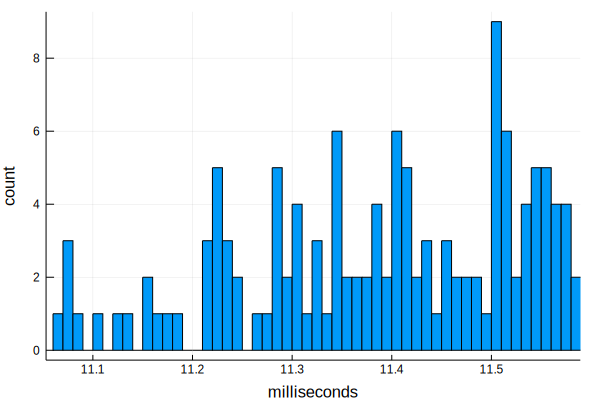

In [17]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [18]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [19]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     6.953 ms (0.00% GC)
  median time:      7.641 ms (0.00% GC)
  mean time:        7.798 ms (0.00% GC)
  maximum time:     14.141 ms (0.00% GC)
  --------------
  samples:          641
  evals/sample:     1

In [20]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

6.952614

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [21]:
# using Pkg; Pkg.add("PyCall")
using PyCall

In [22]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [23]:
pysum(a)

4.999395011261894e6

In [24]:
pysum(a) ≈ sum(a)

true

In [25]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     904.664 ms (0.00% GC)
  median time:      921.824 ms (0.00% GC)
  mean time:        925.090 ms (0.00% GC)
  maximum time:     951.862 ms (0.00% GC)
  --------------
  samples:          6
  evals/sample:     1

In [26]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any,Any} with 3 entries:
  "C"               => 11.063
  "Python built-in" => 904.664
  "C -ffast-math"   => 6.95261

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [27]:
# using Pkg; Pkg.add("Conda")
using Conda

In [ ]:
# Conda.add("numpy")

In [28]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     6.649 ms (0.00% GC)
  median time:      7.565 ms (0.00% GC)
  mean time:        7.963 ms (0.00% GC)
  maximum time:     11.736 ms (0.00% GC)
  --------------
  samples:          627
  evals/sample:     1

In [29]:
numpy_sum(a)

4.999395011261338e6

In [30]:
numpy_sum(a) ≈ sum(a)

true

In [31]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any,Any} with 4 entries:
  "C"               => 11.063
  "Python numpy"    => 6.64861
  "Python built-in" => 904.664
  "C -ffast-math"   => 6.95261

# 5. Python, hand-written 

In [32]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7f32b00fb0c8>

In [34]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 
  memory estimate:  368 bytes
  allocs estimate:  8
  --------------
  minimum time:     1.175 s (0.00% GC)
  median time:      1.192 s (0.00% GC)
  mean time:        1.192 s (0.00% GC)
  maximum time:     1.204 s (0.00% GC)
  --------------
  samples:          5
  evals/sample:     1

In [35]:
sum_py(a)

4.999395011261894e6

In [36]:
sum_py(a) ≈ sum(a)

true

In [37]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any,Any} with 5 entries:
  "C"                   => 11.063
  "Python numpy"        => 6.64861
  "Python hand-written" => 1174.88
  "Python built-in"     => 904.664
  "C -ffast-math"       => 6.95261

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [38]:
@which sum(a)

sum(a::AbstractArray) in Base at reducedim.jl:645

In [39]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     7.426 ms (0.00% GC)
  median time:      8.083 ms (0.00% GC)
  mean time:        8.340 ms (0.00% GC)
  maximum time:     11.340 ms (0.00% GC)
  --------------
  samples:          599
  evals/sample:     1

In [40]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any,Any} with 6 entries:
  "C"                   => 11.063
  "Python numpy"        => 6.64861
  "Python hand-written" => 1174.88
  "Python built-in"     => 904.664
  "Julia built-in"      => 7.42571
  "C -ffast-math"       => 6.95261

# 7. Julia (hand-written) 

In [41]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [42]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     11.346 ms (0.00% GC)
  median time:      12.151 ms (0.00% GC)
  mean time:        12.244 ms (0.00% GC)
  maximum time:     14.773 ms (0.00% GC)
  --------------
  samples:          409
  evals/sample:     1

In [43]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any,Any} with 7 entries:
  "C"                   => 11.063
  "Python numpy"        => 6.64861
  "Julia hand-written"  => 11.3458
  "Python hand-written" => 1174.88
  "Python built-in"     => 904.664
  "Julia built-in"      => 7.42571
  "C -ffast-math"       => 6.95261

# 8. Julia (hand-written w. simd) 

In [44]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [45]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     7.640 ms (0.00% GC)
  median time:      8.281 ms (0.00% GC)
  mean time:        8.445 ms (0.00% GC)
  maximum time:     19.488 ms (0.00% GC)
  --------------
  samples:          592
  evals/sample:     1

In [46]:
mysum_simd(a)

4.999395011261372e6

In [47]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any,Any} with 8 entries:
  "Julia hand-written simd" => 7.63981
  "C"                       => 11.063
  "Python numpy"            => 6.64861
  "Julia hand-written"      => 11.3458
  "Python hand-written"     => 1174.88
  "Python built-in"         => 904.664
  "Julia built-in"          => 7.42571
  "C -ffast-math"           => 6.95261

# Summary

In [48]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................6.6
C -ffast-math...............7.0
Julia built-in..............7.4
Julia hand-written simd.....7.6
C..........................11.1
Julia hand-written.........11.3
Python built-in...........904.7
Python hand-written......1174.9
